# A guide to paticle motion estimation with `pyusel-dispest`

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Define the test data

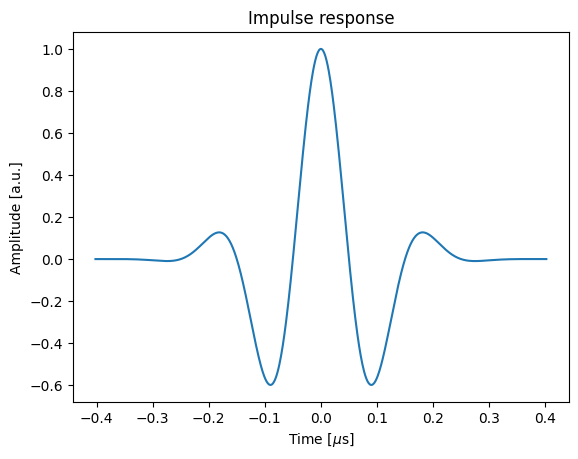

In [2]:
# define the imaging PSF
bw=80/100
f = 5E6
c = 1540
fs = 1E9

tc = sig.gausspulse('cutoff', bw=bw, tpr=-80, fc=f)
Ntc = np.ceil(tc*fs)
timp = (np.arange(2*Ntc+1)-Ntc)/fs
imp = sig.gausspulse(t=timp, bw=bw, tpr=-80, fc=f)

plt.figure()
plt.plot(1E6*timp, imp)
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Amplitude [a.u.]")
plt.title("Impulse response")
plt.show()

In [3]:
def sim_trace(xs, amps, imp, tstart, tstop, fs, c:float=1540):
    if (np.ndim(xs) != 1) or (np.ndim(amps) !=1) or (np.ndim(imp) !=1):
        raise ValueError("xs, amps, and imp must be 1D")
    if len(xs) != len(amps):
        raise ValueError("xs and amps must be the same length")
    
    nt = int((tstop-tstart)*fs)
    t = tstart + np.arange(nt)/fs

    if len(imp) > nt:
        raise ValueError("Time trace mut be bigger than the impulse response")   

    W = np.exp(-2j*np.pi*np.arange(nt)/nt)

    indxs = (2*fs*xs/c)
    amps = amps

    SCAT = 0
    for amp, indx in zip(amps, indxs):
        SCAT += amp * W ** indx
    IMP = np.fft.fft(imp, nt) * W **(-len(imp)/2)
    TRACE = SCAT * IMP
    trace = np.real(np.fft.ifft(TRACE))
    return trace, t

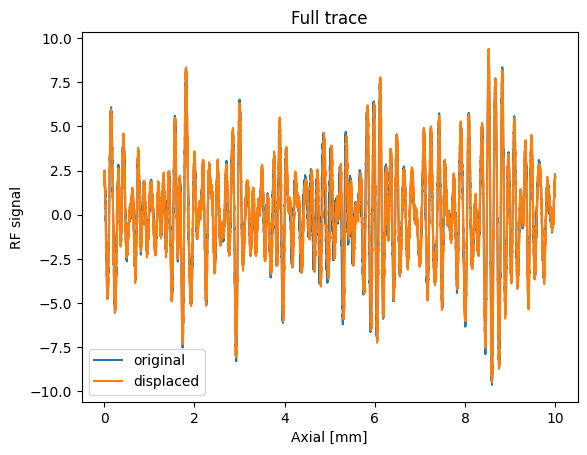

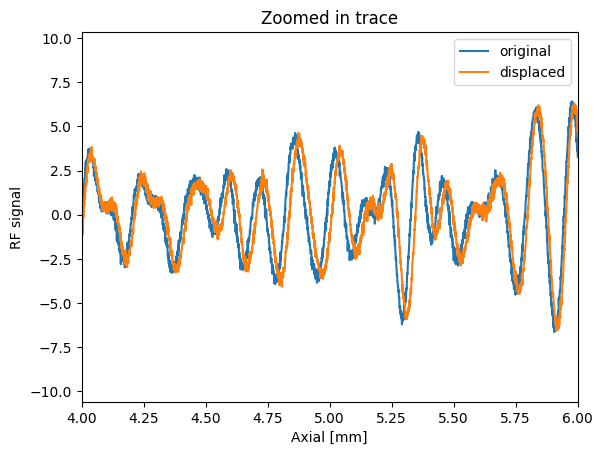

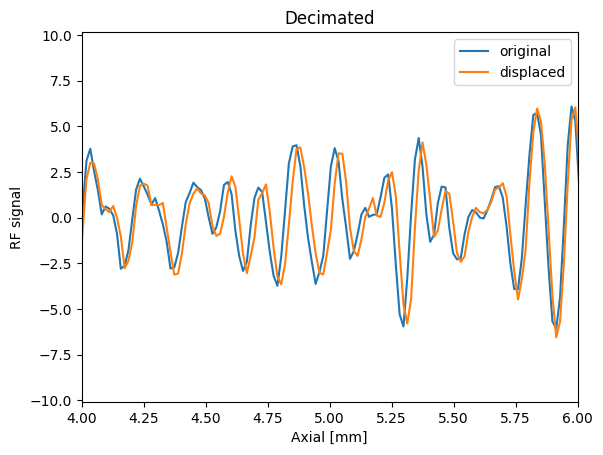

In [4]:
# define the scatterer field
xmin = 0E-6
xmax = 10E-3
Nx = int(1E3)

rng = np.random.default_rng(0)

x0 = rng.uniform(xmin, xmax, Nx)
a0 = rng.normal(0, 1, Nx)


# Undisplaced signal
trace0, t = sim_trace(x0, a0, imp, 0, 20E-3/c, fs, c)
x = c*t/2
trace0 += np.ptp(trace0) * rng.normal(0, 0.01, trace0.shape)

# define the displacement field
f_disp = lambda x, mag=20E-6: mag*np.exp(-(x-5E-3)**2/(1E-3**2))

x1 = x0 + f_disp(x0)

# displaced signal
trace1, _ = sim_trace(x1, a0, imp, 0, 20E-3/c, fs, c)
trace1 += np.ptp(trace0) * rng.normal(0, 0.01, trace1.shape)

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(4, 6)
plt.show()

plt.figure()
plt.plot(1E3*x[::20], trace0[::20], label='original')
plt.plot(1E3*x[::20], trace1[::20], label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Decimated")
plt.xlim(4, 6)
plt.show()

## Displacement estimation using Kasai algorithm

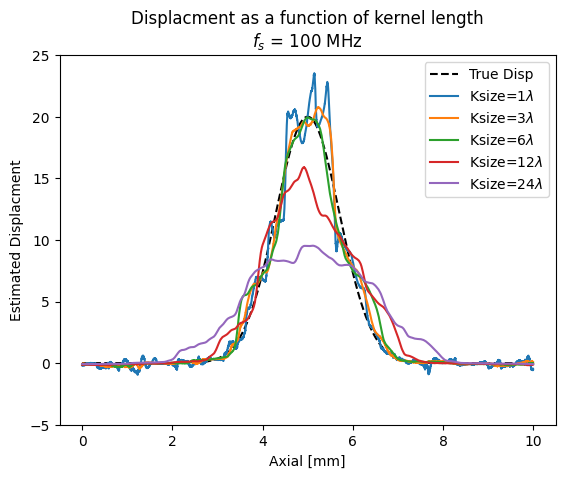

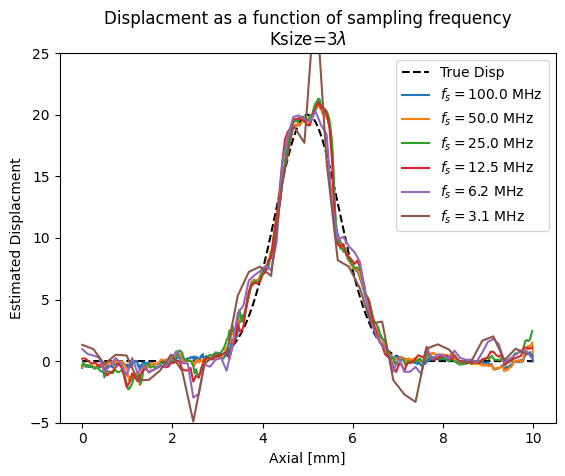

In [5]:
from dispest import calc_kasai

# convert rfsignal to IQ to get phase information
IQ0 = sig.hilbert(trace0).reshape((-1,1))
IQ1 = sig.hilbert(trace1).reshape((-1,1))
IQ = np.concatenate((IQ0, IQ1), axis=1)
I = np.real(IQ)
Q = np.imag(IQ)

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*f_disp(x), color='k', linestyle='--', label='True Disp')

disps = []
for lam in [1, 3, 6, 12, 24]:
    ksize = int(np.round(lam*fs/(f)))
    disp = calc_kasai(I, Q, taxis=1, fd=f, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x, disp, linestyle='-', label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of kernel length\n$f_s$ = 100 MHz")
plt.show()

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*f_disp(x), color='k', linestyle='--', label='True Disp')

disps = []
lam=3
for dec in [10, 20, 40, 80, 160, 320]:
    ksize = int(np.ceil(lam*fs/(dec*f)))
    disp = calc_kasai(I[::dec,:], Q[::dec,:], taxis=1, fd=f, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x[::dec], disp, linestyle='-', label=  "$f_s=" + f"{fs/(1E6*dec):0.01f}" + "$ MHz")

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of sampling frequency\nKsize=3$\\lambda$")
plt.show()


# Normalized Cross correlation

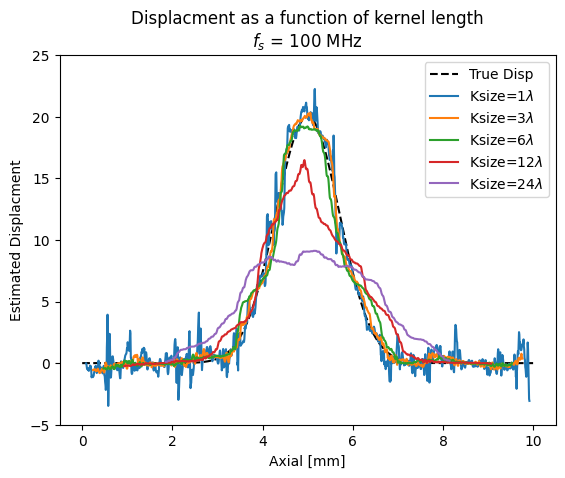

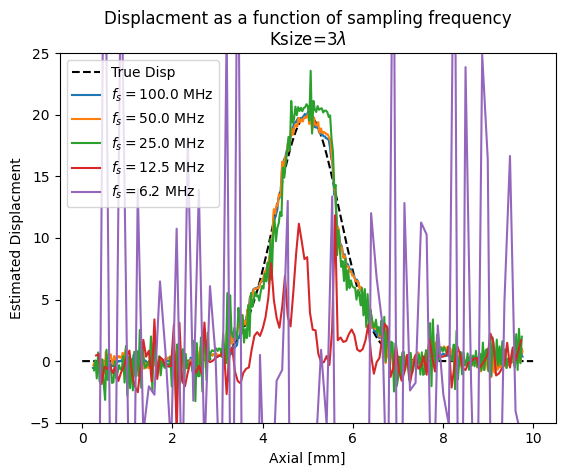

In [6]:
from dispest import get_xcorr_inds, nxcorr_by_inds_mu

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*f_disp(x), color='k', linestyle='--', label='True Disp')

disps = []
dec = 10
ilam = int(np.ceil(fs/(dec*f)))
rhos = []
for lam in [1, 3, 6, 12, 24]:
    ksize = int(np.ceil(lam*fs/(dec*f)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    selref, selser, outbnd, seliref, imid = get_xcorr_inds(len(t0dec), ksize, 1, ilam//2)

    idx, rho = nxcorr_by_inds_mu(t0dec, t1dec, selref, selser, outbnd, seliref)
    rhos.append(rhos)
    dx = 1E6*dec*c*idx/(2*fs)
    xest = 1E3*c*dec*imid/(2*fs)

    plt.plot(xest, dx, label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of kernel length\n$f_s$ = 100 MHz")
plt.show()

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*f_disp(x), color='k', linestyle='--', label='True Disp')


disps = []
lam=3
rhos = []
for dec in [10, 20, 40, 80, 160]:
    ksize = int(np.ceil(lam*fs/(dec*f)))
    ilam = int(np.ceil(fs/(dec*f)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    selref, selser, outbnd, seliref, imid = get_xcorr_inds(len(t0dec), ksize, 1, ilam//2)

    idx, rho = nxcorr_by_inds_mu(t0dec, t1dec, selref, selser, outbnd, seliref)
    rhos.append(rhos)
    dx = 1E6*dec*c*idx/(2*fs)
    xest = 1E3*c*dec*imid/(2*fs)

    plt.plot(xest, dx, label="$f_s=" + f"{fs/(1E6*dec):0.01f}" + "$ MHz")

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of sampling frequency\nKsize=3$\\lambda$")
plt.show()